## Option Pricing Model

In this section I aim to perform option pricing from a machine learning standpoint. Option prices can be calculated based on several inputs that are broadcasted by a broker. These include the 5-greeks, strike price, underlying price etc. 

I will frame option's pricing as a regression problem and will construct a model that predicts option prices based on current known statistics such as the greeks, strike etc. 

The model choice for regression is XGBoost. Given more time, I would utilise a variety of models such as Support Vector Regressors, GAMs, ANNs etc and choose the best. 

### 1.0 Importing Necessary Modules

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import seaborn as sns
import sklearn as sk

### 2.0 Data Loading and Pre-processing

We load the data set used to train this model.

About the dataset:
The dataset used  is the L3 Historical CSV Data Sample. This dataset comprises of 928674 observations of put and call European Options traded on the CBOE. 

In [3]:
data = pd.read_csv('/Users/kartikeyabisht/Desktop/Sample_L3_20190815/L3_options_20190815.csv')
print(data.columns)
print(len(data))

Index(['UnderlyingSymbol', 'UnderlyingPrice', 'Flags', 'OptionSymbol', 'Type',
       'Expiration', ' DataDate', 'Strike', 'Last', 'Bid', 'Ask', 'Volume',
       'OpenInterest', 'T1OpenInterest', 'IVMean', 'IVBid', 'IVAsk', 'Delta',
       'Gamma', 'Theta', 'Vega', 'AKA'],
      dtype='object')
928674


We can see that the main features are ['UnderlyingSymbol', 'UnderlyingPrice', 'Flags', 'OptionSymbol', 'Type',
       'Expiration', ' DataDate', 'Strike', 'Last', 'Bid', 'Ask', 'Volume',
       'OpenInterest', 'T1OpenInterest', 'IVMean', 'IVBid', 'IVAsk', 'Delta',
       'Gamma', 'Theta', 'Vega', 'AKA']


#### 2.1 First level of feature selection

The OptionSymbol and AKA are treated as labels for the options and thus will not be incorporated into the regression model. 

In reality, the identity of the underlying MAY have an impact on the pricing of its option and we would investigate if there is an statistical relationship. 

'Last' - the last trading price of the option is also discarded. 

Our dataset contains the feature 'IVMean' - this is the mean between the bid implied volatility of the option and the ask implied volatility. This is not necessarily equal to the true IV of the option. For future improvements, we would incorporate a market-maker's IV estimates OR our own (through methods such as those in Malliaris and Salchenberger 1996) in our model. 

In [4]:
data = data.drop(['Flags', 'UnderlyingSymbol','OptionSymbol', 'AKA','Last', 'IVBid', 'IVAsk'], axis = 1)
print(data.isna().sum(axis = 1).sum())

print(len(data))
data = data.loc[(data != 0).any(1)]
print(len(data))


0
928674
928674


/var/folders/9w/bgjm8ttd5qbdnb216z7gzgs00000gn/T/ipykernel_76163/809435403.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  data = data.loc[(data != 0).any(1)]


There are no entried with NA, NAN etc.

#### 2.2 Feature Engineering

Firstly, we want to determine an appropriate "price" for the options based on the bid-ask quoted. Here we make the assumption that the market makers have a "theo" - theoretical fair value of the option at present & that they construct their bid-ask quotes around this Theo with a uniform width. 

Secondly, we want to determine the time to expiration for each of the options 

Thirdly, we want to determine the difference between our strike price & underlying price to arrive at a single scale that establishes whether an option is in,at,out-the money. 

In [5]:
data['Theo'] = (data['Bid']+data['Ask'])/2
data['Expiration'] = pd.to_datetime(data['Expiration'])
data[' DataDate'] = pd.to_datetime(data[' DataDate'])

data['time_to_exp'] = data['Expiration']-data[' DataDate']
data['time_to_exp'] = data['time_to_exp'].dt.days

data['diff_to_strike'] = data['Strike'] - data['UnderlyingPrice']

data = data.drop(['Expiration', ' DataDate', 'Bid', 'Ask'], axis = 1)

#### 2.3 Outlier Detection & Removal

We utilise the Local Outlier Factort (LOF) Algorithm for anomaly detection
- In Summary: the LOF algo computes a score that measures the local density deviation of a given data point with respect to it's neighbors
- a more detailed explaination of the process is available in the original paper: https://www.dbs.ifi.lmu.de/Publikationen/Papers/LOF.pdf

- 1) First we use the LOF to get a score of 1, -1 (outlier)
  2) Secondly, we create two data sets; one for calls & one for puts with the outliers removed

In [22]:
from sklearn.neighbors import LocalOutlierFactor

data_calls = data[data['Type']=='call']
data_puts = data[data['Type']=='put']
data_calls = data_calls.drop('Type', axis=1)
data_puts = data_puts.drop('Type', axis=1)

data_calls = data_calls.reset_index().drop('index', axis=1)
data_puts = data_puts.reset_index().drop('index', axis =1)

clf_calls = LocalOutlierFactor()
clf_puts = LocalOutlierFactor()
call_LOF = clf_calls.fit_predict(data_calls)
put_LOF = clf_puts.fit_predict(data_puts)


Frist we split our data sets into call & puts.
We then calculated the LOF for each data entry and this is call_LOF & put_LOF

Below we define a function that generates two dataframes for the call AND put datasets - one filled with inliers and one filled with outliers. Thus it effectively partitions our call/put datasets

In [23]:
def inlier_outlier_sep(LOF,dataset):
    LOF_df = pd.DataFrame(LOF)
    inlier_index_vals = LOF_df.index[LOF_df[0]==1].to_list()
    outlier_index_vals = LOF_df.index[LOF_df[0]==-1].to_list()
    inlier = dataset.iloc[inlier_index_vals]
    outlier = dataset.iloc[outlier_index_vals]
    return (inlier, outlier)

call_inlier, call_outlier = inlier_outlier_sep(call_LOF, data_calls)
puts_inlier, puts_outlier = inlier_outlier_sep(put_LOF, data_puts)

Finally, we combine the put & call filtered datasets into a single dataframe, whilst also reassigning their classification as a put or call.

We also shuffle the rows of the dataframe so as to distribute "call" & "put" option types throughout the data frame. This is important as later one we will be using cross-validation that relies on splitting the data set into different folds

In [45]:
call_inlier['Type'] = 'call'
puts_inlier['Type'] = 'put'
final_train_data = pd.concat([call_inlier, puts_inlier])
final_train_data = final_train_data.sample(frac=1).reset_index().drop('index', axis = 1)
print(len(final_train_data))
print(len(data))

/var/folders/9w/bgjm8ttd5qbdnb216z7gzgs00000gn/T/ipykernel_76163/886661642.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  call_inlier['Type'] = 'call'
/var/folders/9w/bgjm8ttd5qbdnb216z7gzgs00000gn/T/ipykernel_76163/886661642.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  puts_inlier['Type'] = 'put'


899604
928674


We can see that we have removed around 29000 points that were classified as outliers using the Local Outlier Factor model

Finally, we one hot-incode the data regarding option type

In [46]:
final_train_data[['call', 'put']]=pd.get_dummies(final_train_data['Type'])
final_train_data = final_train_data.drop('Type', axis = 1)


### SUMMARY of the XGBoost (Extreme Gradient Boosting) Model for regression

XGBoost is a type of gradient boosting that utilises trees. Gradient Boosting models predict a target variable by combining estimates from several weaker models (trees for XGBoost). XGBoost is called a stagewise additive model because: 
- Additive: final output from the model is a linear sum of all predictions
- Stagewise: as we build the M trees, the output from the ALL the trees uptil and including the (m-1)st tree "guides" the construction of the next (m)th tree

An intuitive diagram of the algorithm is provided below (source: AWS Sagemaker guides)
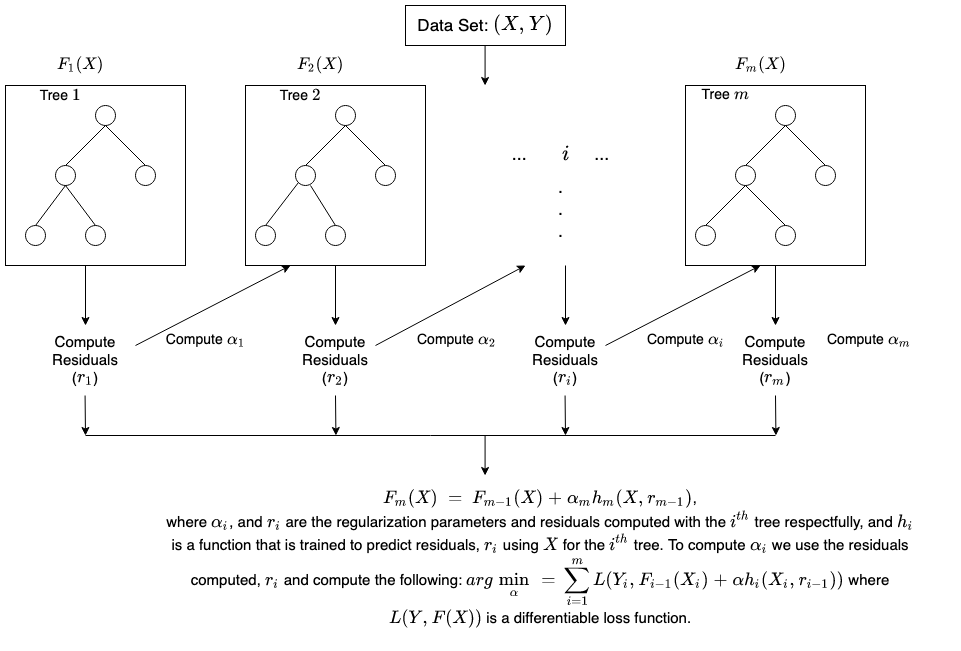

XGBoost works by minimising a regularized (L1, L2, others*) objective function. This function combines a convex loss function (typically squared error) AND a model complexity penalty term. 

In essence; training of the model proceeds iteratively whereby new trees are added that predict the residuals of prior trees. 

An indepth description of XGBoost is given in the "Algorithms used" file. 




### 3.0 Feature Selection by Exhaustion

We now carry out feature selection in the following manner: 

1) Certain features have to be included in our model every time - these are determined by a review of option pricing literature. These are in the list "features_non_optional". optional features are placed in the list "features_optional" -- we use itertools to create a list of all possible combinations of features that can be used in our model

2) For each possible feature set we determine the best performing model by using Tree of Parzen Estimation (TPE) based hyper-parameter tuning. We utilise the HyperOpt library for this 

#### 3.1 Creating All possible Feature subsets

In [48]:
import itertools

features_optional = ['Volume', 'OpenInterest', 'T1OpenInterest']
features_non_optional = ['Delta', 'Gamma', 'Theta', 'Vega','time_to_exp', 'diff_to_strike', 'call', 'put', 'IVMean']
feature_subsets = []
for n in np.arange(len(features_optional)+1):
    for x in list(itertools.combinations(features_optional, n)):
        x = list(x) + features_non_optional
        feature_subsets.append(x)

print(len(feature_subsets))

8


As a sanity check we can see that we should have  3c0+ 3c1 + 3c2 + 3c3 = 8 combinations. This matches the number of subsets in our list above. These 8 combinations are:

In [49]:
print(feature_subsets)

[['Delta', 'Gamma', 'Theta', 'Vega', 'time_to_exp', 'diff_to_strike', 'call', 'put', 'IVMean'], ['Volume', 'Delta', 'Gamma', 'Theta', 'Vega', 'time_to_exp', 'diff_to_strike', 'call', 'put', 'IVMean'], ['OpenInterest', 'Delta', 'Gamma', 'Theta', 'Vega', 'time_to_exp', 'diff_to_strike', 'call', 'put', 'IVMean'], ['T1OpenInterest', 'Delta', 'Gamma', 'Theta', 'Vega', 'time_to_exp', 'diff_to_strike', 'call', 'put', 'IVMean'], ['Volume', 'OpenInterest', 'Delta', 'Gamma', 'Theta', 'Vega', 'time_to_exp', 'diff_to_strike', 'call', 'put', 'IVMean'], ['Volume', 'T1OpenInterest', 'Delta', 'Gamma', 'Theta', 'Vega', 'time_to_exp', 'diff_to_strike', 'call', 'put', 'IVMean'], ['OpenInterest', 'T1OpenInterest', 'Delta', 'Gamma', 'Theta', 'Vega', 'time_to_exp', 'diff_to_strike', 'call', 'put', 'IVMean'], ['Volume', 'OpenInterest', 'T1OpenInterest', 'Delta', 'Gamma', 'Theta', 'Vega', 'time_to_exp', 'diff_to_strike', 'call', 'put', 'IVMean']]


#### 3.2 Hyperparameter Tuning (Round 1)

First we define our Hyperparameter(s))

- Our regularisation HP are: 'reg_alpha', 'reg_lambda', 'learning_rate', 'max_delta_step'
- Our pruning parameters are: 'min_split_loss', 'max_depth', 'min_child_weight'
- n_estimators controls how many models (M) are made.
- Sampling parameters are: 'subsample':row sample proportion, 'colsample_bytree', 'colsample_bylevel','colsample_bynode'

Note when we initialise our model we also define booster = 'gbtree' and 'eval_metric' = 'RMSE'

The search space for these Hyperparameters is:
- learning rate:  log space between -5 and 0 base 10
- reg_alpha = log space between 0 and 1000
- reg_lambda = log space between 0 and 1000
- max_depth: log space between 5 and 1000
- min_split_loss = log space between 0 and 100
- max_delta_step = recommended range is 1 to 10
- min_child_weight = log space between 0 and 100
- subsample/colsamples = uniform between 0 and 1
- N_estimators should be as such: [20, 50, 100, 200, 500, 1000, 2000]

Below we split our data into train & test sets. We also define a 5-Fold Cross-validator

In [67]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

Y = final_train_data['Theo']
X = final_train_data.drop('Theo', axis = 1)

random_state = 40
train_data, test_data, train_targets, test_targets = train_test_split(X,Y,test_size=0.20, shuffle = True, random_state=random_state)
num_folds =5
kf = KFold(n_splits=num_folds, random_state=random_state, shuffle=True)


We define our regressor as well as the Hyperparameter search space/grid. We first carry out gridsearch as a quick hyper-parameter tuning method

In [2]:
reg = xgb.XGBRegressor(booster='gbtree', eval_metric='rmse', random_state=random_state)
param_grid = {"learning_rate":np.logspace(-5,0, num = 20, endpoint=True, base=10.0), "reg_alpha": np.logspace(-2,3, num=10, endpoint=True), "reg_lambda":np.logspace(-2,3, num=10, endpoint=True),"min_child_weight": np.logspace(-2, 3, num=10, endpoint=True), "max_delta_step":[0,2,4,6,8,10], "min_split_loss": np.logspace(-2,3,num=10, endpoint = True),"n_estimators":[100, 200, 500, 1000, 2000, 5000], "subsample":np.linspace(0,1,num=10, endpoint=False), "colsample_bytree":np.linspace(0,1,num=10, endpoint=False), "colsample_bylevel":np.linspace(0,1,num=10, endpoint=False), "colsample_bynode":np.linspace(0,1,num=10,endpoint=False)}

from sklearn.model_selection import GridSearchCV

gs=GridSearchCV(reg, param_grid,scoring='neg_mean_squared_error',cv=kf, verbose=False)
gs.fit(train_data[feature_subsets[0]], train_data)
gs_test_score = mean_squared_error(test_targets[feature_subsets[0]], gs.predict(test_data))

print("Best MSE {:.3f} params {}".format(-gs.best_score_, gs.best_params_))

NameError: name 'xgb' is not defined

We look at how the parameters have changed from iteration to iteration. This can give a better idea of what aprameters to choose/eliminate

In [ ]:
gs_results_df=pd.DataFrame(np.transpose([-gs.cv_results_['mean_test_score'],
                                         gs.cv_results_['param_learning_rate'].data,
                                         gs.cv_results_['param_max_depth'].data,
                                         gs.cv_results_['param_max_depth'].data,
                                         gs.cv_results_['param_max_depth'].data,
                                         gs.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
gs_results_df.plot(subplots=True,figsize=(10, 10))

Now we define a report function that reports back the best hyperparameters as well as the model performance

Now we carry out the HP tuning for each subset for the 20 random seeds

In [ ]:

#we make a dictionary that contains the FEATURE SUBSET & their respective BEST HP models
X1 = final_train_data[feature_subsets[0]]; X4 = final_train_data[feature_subsets[3]]; X7 = final_train_data[feature_subsets[6]]
X2 = final_train_data[feature_subsets[1]]; X5 = final_train_data[feature_subsets[4]]; X8 = final_train_data[feature_subsets[7]]
X3 = final_train_data[feature_subsets[2]]; X6 = final_train_data[feature_subsets[5]]

Y = final_train_data['Theo']

#We notice that when 8 features are used, the best score is 0.82, 9 features = 0.746, 0.5555, 0.6197, 0.780, 10 features = 0.9338, 0.460, 0.9325, 0.9329, 0.779294, 0.705705,  11 features = 0.796, 0.890236, 0.8839, 0.7775
#Therefore we can see that we ONLY need 9 features (the non-optional 8 & one optional.)
#Furthermore, the performance of the model X3 (non-optional features + OPEN INTEREST) is the best - thus our feature selection eliminates volume, T1OpenInterest & IVMean


###FURTHER HYPERPARAMETER TUNING

#{'colsample_bylevel': 0.6000000000000001, 'colsample_bynode': 0.2, 'colsample_bytree': 0.30000000000000004, 'learning_rate': 0.04832930238571752, 'max_delta_step': 0, 'min_child_weight': 0.1291549665014884, 'min_split_loss': 5.994842503189409, 'reg_alpha': 21.544346900318846, 'reg_lambda': 0.01, 'subsample': 0.1, 'n_estimators': 100}
#for model Index(['OpenInterest', 'Delta', 'Gamma', 'Theta', 'Vega', 'time_to_exp',
       #'diff_to_strike', 'call', 'put'],
      #dtype='object'), the best score was 0.5555709182731629

#to carry out a more robust sensitivity analysis for our hyperparameters we may want to use: https://hal.science/hal-03128298/document in the future
import random
list = []
for a in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    random.seed(a)
    search_final=HpBandSterSearchCV(reg,param_dist,random_state=0,cv=5,optimizer='bohb').fit(X3,Y)
    list.append(search_final.best_params_)
df = pd.DataFrame(list)
print(dict(df.mean()))

#From this we see our model gives averaged values for the "optimal" hyperparameters
#{'colsample_bylevel': 0.34, 'colsample_bynode': 0.46, 'colsample_bytree': 0.5, 'learning_rate': 0.3435704061541234, 'max_delta_step': 5.866666666666666, 'min_child_weight': 68.33691472546926, 'min_split_loss': 99.66747875289484, 'reg_alpha': 110.54463429130537, 'reg_lambda': 281.3451677407781, 'subsample': 0.5266666666666667, 'n_estimators': 95.53333333333333}






######SAVING the MODEL
from pickle import dump
from pickle import load